In [2]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [1]:
import tensorflow as tf
import os

# Load and preprocess image function
def load_and_preprocess_image(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    filename = parts[-1]
    
    x_label = tf.strings.substr(filename, 11, 3)
    y_label = tf.strings.substr(filename, 14, 3)
    x_label = tf.where(tf.strings.regex_full_match(x_label, r'\+0\+'), '0', x_label)
    x_label = tf.where(tf.strings.regex_full_match(x_label, r'\+0\-'), '0', x_label)
    y_label = tf.strings.regex_replace(y_label, '0.j', '+0')
    y_label = tf.strings.regex_replace(y_label, r'\.+', '')

    x_label = tf.strings.to_number(x_label, out_type=tf.float32) / 180.0  # Normalize
    y_label = tf.strings.to_number(y_label, out_type=tf.float32) / 180.0  # Normalize

    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [64, 64])
    image = tf.image.rgb_to_grayscale(image)
    image = tf.image.per_image_standardization(image)  # Normalizing the image

    return image, tf.stack([x_label, y_label])

# Function to randomly rotate an image
def random_rotate_image(image):
    image = tf.keras.preprocessing.image.random_rotation(image.numpy(), 10)
    return tf.convert_to_tensor(image, dtype=tf.float32)

# Augment image function
def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.3)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.py_function(random_rotate_image, [image], [tf.float32])[0]
    image.set_shape([64, 64, 1])  # Ensure the shape is (64, 64, 1) after augmentation
    return image, label

# Setting up dataset
dataset_dir = "D:\\03_Projects\\01_CNN\\DATA1"
image_paths = tf.data.Dataset.list_files(os.path.join(dataset_dir, '*.jpg'))
full_dataset = image_paths.map(load_and_preprocess_image)
full_dataset = full_dataset.shuffle(buffer_size=1000)

# Split dataset
train_size = int(0.7 * 2800)
val_size = int(0.15 * 2800)
train_dataset = full_dataset.take(train_size).map(augment_image).batch(32)
val_dataset = full_dataset.skip(train_size).take(val_size).batch(32)
test_dataset = full_dataset.skip(train_size + val_size).batch(32)

# Model definition
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(64, 64, 1)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(2)
    ])
    return model

# Build and compile the model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

model = build_model()
model.compile(optimizer=Adam(learning_rate=0.00001), loss='mse', metrics=['mae'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Train the model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=50, callbacks=[early_stopping, model_checkpoint, reduce_lr])

# Evaluate the model
test_loss, test_mae = model.evaluate(test_dataset)
print("Test Loss:", test_loss)
print("Test MAE:", test_mae)


Epoch 1/50


C:\Users\sopit\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


62/62 ━━━━━━━━━━━━━━━━━━━━ 26s 307ms/step - loss: 3.1560 - mae: 1.2681 - val_loss: 0.6901 - val_mae: 0.2521 - learning_rate: 1.0000e-05
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 19s 299ms/step - loss: 2.5708 - mae: 1.0986 - val_loss: 0.7064 - val_mae: 0.2728 - learning_rate: 1.0000e-05
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 19s 303ms/step - loss: 2.2579 - mae: 1.0201 - val_loss: 0.7667 - val_mae: 0.3413 - learning_rate: 1.0000e-05
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 19s 302ms/step - loss: 2.0544 - mae: 0.9444 - val_loss: 0.8208 - val_mae: 0.3877 - learning_rate: 1.0000e-05
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 19s 299ms/step - loss: 1.8874 - mae: 0.8919 - val_loss: 0.8408 - val_mae: 0.3949 - learning_rate: 1.0000e-05
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 19s 300ms/step - loss: 1.7537 - mae: 0.8516 - val_loss: 1.0343 - val_mae: 0.5519 - learning_rate: 1.0000e-05
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 19s 300ms/step - loss: 1.6211 - mae: 0.7913 - val_loss: 0.9619 - val_mae: 0.4889 - learning

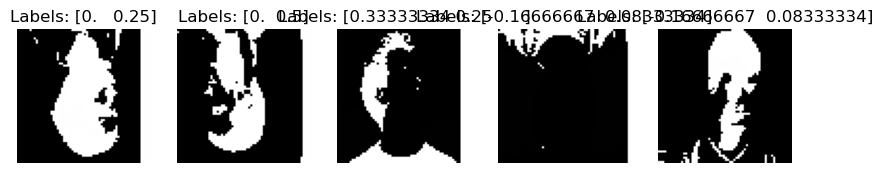

In [5]:
import matplotlib.pyplot as plt

def show_images(dataset, num_images=5):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(num_images):
            ax = plt.subplot(1, num_images, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')
            plt.title(f"Labels: {labels[i].numpy()}")
            plt.axis("off")
    plt.show()

# Show augmented images from the training set
show_images(train_dataset)



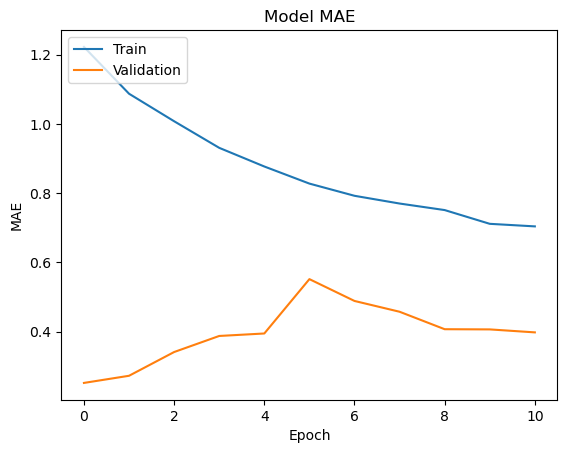

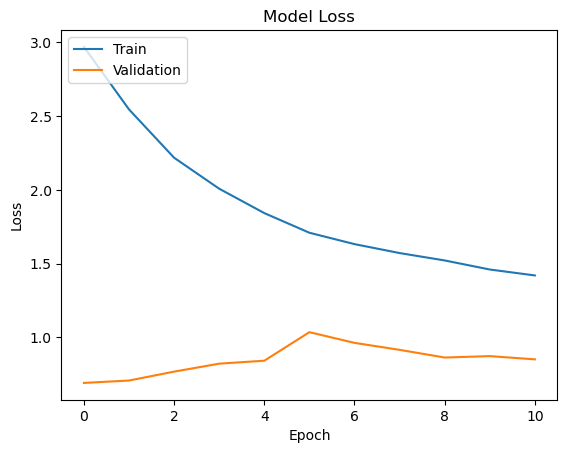

In [43]:
import matplotlib.pyplot as plt

# Summarize history for accuracy
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [47]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming test_dataset contains the testing data and labels
y_pred = []
y_true = []
for images, labels in test_dataset:
    preds = model.predict(images)
    # Assuming a regression problem, convert preds to discrete class labels if needed
    # For example, if predicting angles that have been binned into classes
    pred_classes = np.argmax(preds, axis=1)
    true_classes = np.argmax(labels.numpy(), axis=1)
    y_pred.extend(pred_classes)
    y_true.extend(true_classes)

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━

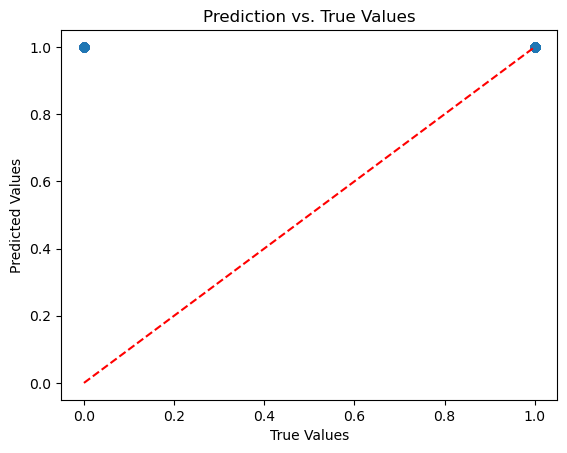

In [49]:
plt.scatter(y_true, y_pred, alpha=0.3)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Prediction vs. True Values')
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')  # Diagonal line
plt.show()


Filename 'person14244+0-30.jpg' does not match expected pattern.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
Filename 'person06138-15+75.jpg' does not match expected pattern.
Filename 'person11221-30+15.jpg' does not match expected pattern.
Filename 'person12178+30+90.jpg' does not match expected pattern.


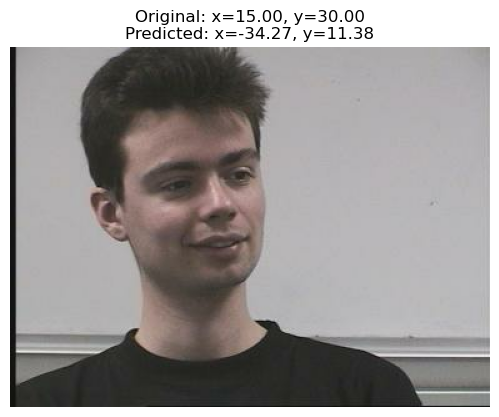

In [81]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import random

# Load the trained model
model = tf.keras.models.load_model('best_model.keras')

# Function to preprocess image
def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [64, 64])
    image = tf.image.rgb_to_grayscale(image)
    image = tf.image.per_image_standardization(image)  # Normalizing the image
    image = tf.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Function to extract angles from filename
def extract_angles_from_filename(filename):
    parts = filename.replace('.jpg', '').replace('.png', '').split('-')
    if len(parts) < 3:
        raise ValueError(f"Filename '{filename}' does not match expected pattern.")
    x_label = float(parts[1])
    y_label = parts[2]
    if y_label.startswith('+'):
        y_label = y_label[1:]  # Remove the leading '+'
    y_label = float(y_label)
    return x_label / 180.0, y_label / 180.0  # Normalize

# Function to display image with original and predicted angles
def display_prediction(image_path, original_angle, predicted_angle):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    plt.imshow(tf.squeeze(image), cmap='gray')
    original_x, original_y = original_angle
    predicted_x, predicted_y = predicted_angle
    plt.title(f"Original: x={original_x*180:.2f}, y={original_y*180:.2f}\n"
              f"Predicted: x={predicted_x*180:.2f}, y={predicted_y*180:.2f}")
    plt.axis("off")

# Directory containing the images
dataset_dir = 'D:\\03_Projects\\01_CNN\\DATA1'

# Get list of all image files in the dataset directory
image_files = [os.path.join(dataset_dir, f) for f in os.listdir(dataset_dir) if f.endswith('.jpg')]

# Select 5 random images
random_images = random.sample(image_files, 5)

# Create a figure to display the images
plt.figure(figsize=(15, 10))

for i, image_path in enumerate(random_images):
    filename = os.path.basename(image_path)
    
    try:
        # Extract original angles from filename
        original_angle = extract_angles_from_filename(filename)
    except ValueError as e:
        print(e)
        continue  # Skip this image if the filename pattern does not match

    # Preprocess the image
    preprocessed_image = preprocess_image(image_path)

    # Predict the angle using the trained model
    predicted_angle = model.predict(preprocessed_image)[0]

    # Display the image with original and predicted angles
    plt.subplot(2, 3, i + 1)
    display_prediction(image_path, original_angle, predicted_angle)

plt.tight_layout()
plt.show()


In [53]:
loss, accuracy = model.evaluate(test_dataset)
print(f"Test Loss (MSE): {loss}")
print(f"Test Mean Absolute Error (MAE): {accuracy}")



421/421 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.6891 - mae: 0.2497
Test Loss (MSE): 0.6920342445373535
Test Mean Absolute Error (MAE): 0.2533913552761078
